# Image recognition: classifying landcover (EuroSAT) using Distance Metric Learning


#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

## Introduction

This tutorial shows how to do whole image classification, or image `recognition`, starting from JPEG image files. We demonstrate the workflow on the [EuroSAT](https://arxiv.org/abs/1709.00029) landcover/use classification dataset

Many approaches in machine learning require a measure of distance between data points (Euclidean, City-Block, Cosine, etc.). Here we use a "weakly supervised" machine learning framework based on distance metrics, using the concept of maximizing the distance between classes in embedding space.

This so-called "Metric Learning" aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs, as defined by the training scheme, are located close to each other. 

Imagery is embedded into a high-dimensional space such that similar inputs, as defined by a distance metric, are located close to each other. 

The goal is to learn a set of neural network filter weights that optimally puts the positive pairs closer together than either pairing of positive and negative samples, as defined by a distance metric, which is therefore considered a loss function. 

The model is trained in batches. A batch consists of (anchor, positive) pairs spread across the classes. An anchor is a randomly chosen image and a positive is another randomly chosen image of the same class. The goal of learning will be to move the anchor and positive pairs closer together and further away from other instances in the batch. In this case the batch size will be dictated by the number of classes. This is "weakly supervised" because one model training epoch only distinguishes between the anchor class image and positive class image, and the classes of all other images. This differs from state-of-the-art strongly supervised workflows that distinguish between all classes in the batch explicitly using all images of each class. 

The training scheme utilized here consists of an autoencoder neural network that maps an image to an embedding. This model first consists of a sequence of 2d convolutions followed by global pooling with a final linear projection to an embedding space. This part of the model serves as an automated image feature extractor. In the second part of the model, the embeddings are normalized such that the inner product of a sample embedding is used to measure similarity (cosine distance). The model is trained as an optimization problem where the goal is to minimize the positive pair cosine distance within the high-dimensional embedded space.

For more details on this approach, see this [talk](https://www.youtube.com/watch?v=Jb4Ewl5RzkI) by Matthew Kelcey, who is the originator of the modeling approach we are using here. This notebook is based heavily on the workflow on the keras [examples](https://keras.io/examples/vision/metric_learning/) page, with the following differences:

* We use a larger scalar to normalize logits (the unnormalized outputs of a model).
* We use 16 embedding dimensions rather than 8
* We use a learning rate of 10^4 rather than 10^3
* We use an ensemble of models over varying nearest neighbors, which serves to 
 * increase overall accuracy, and
 * provide a means with which to compute sensitivity to the number of nearest neighbors, per class. This metric might be useful in examining per-class prediction confidence  
* We show how to use the ensemble model in predictive mode on a sample test image, and rank each class by likelihood
* We use dimensionality reduction and clustering algorithms to further explore the class separation in embedded space

In the end, we have a model that is accurate over all classes, using only weak supervision, and we have ways to evaluate the sensitivity of each class to the "number of nearest neighbours" hyperparameter. Finally, we can visualize the model's decision surface in only two dimensions



## Setup

Import the tensorflow and keras libraries and functions we'll need

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Import other libraries

In [4]:
import requests, os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter

## Load the data: EuroSAT


The following function allows us to download a file on google drive

In [5]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

First, let's download the 106M zip archive of the raw data:

In [6]:
file_id = '1dBfQw66GbggsvnTKQuiiKBy6UqQHdQO-'

destination = 'EuroSAT.zip'
download_file_from_google_drive(file_id, destination)

In this example I have pre-sorted the imagery into train and test splits, by randomly selecting from among the images in each class

Unzip both zipped files (piping output to `tmp.txt` so we don't clutter our screens with lots of output) 

In [7]:
!unzip EuroSAT.zip > tmp.txt

What categories do we have?

In [8]:
!ls EuroSAT

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


Make a new directory `EuroSAT_test`, and rename the `EuroSAT` directory `EuroSAT_train`

In [9]:
!mkdir EuroSAT_test

In [10]:
!mv EuroSAT EuroSAT_train

## Generate a Dataset

Set the batch size (number of images the model trains on at any one time)

In [11]:
batch_size = 16

Get a list of subdirectories as classes

In [12]:
D = []
for k in os.walk('EuroSAT_train'):
  D.append(k)

In [13]:
classes = sorted(D[0][1])
print(classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Use system commands to 
1. create a subdirectory for each class under `test`
2. move a random subset of 1000 images from train to test

In [14]:
for k in classes:
  print("Creating test set for %s" % (k))
  os.system('mkdir EuroSAT_test/'+k)
  os.system('shuf -zn1000 -e ./EuroSAT_train/'+k+'/*.jpg | xargs -0 mv -vt ./EuroSAT_test/'+k+'/')

Creating test set for AnnualCrop
Creating test set for Forest
Creating test set for HerbaceousVegetation
Creating test set for Highway
Creating test set for Industrial
Creating test set for Pasture
Creating test set for PermanentCrop
Creating test set for Residential
Creating test set for River
Creating test set for SeaLake


The following commands count how many images are in the `EuroSAT_train/River` and `EuroSAT_test/River` folders 

In [15]:
!ls EuroSAT_train/River | wc -l

1500


In [16]:
!ls EuroSAT_test/River | wc -l

1000


Get rid of corrupted image files

In [17]:
num_skipped = 0
for folder in ['EuroSAT_test', 'EuroSAT_train']:
  for folder_name in classes:
    folder_path = os.path.join(folder, folder_name)
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      fobj = open(fpath, 'rb')
      if tf.compat.as_bytes('JFIF') not in fobj.peek(10):
          num_skipped += 1
          # Delete corrupted image
          os.system('rm ' + fpath)
  print('Deleted %d images' % num_skipped)

Deleted 1 images
Deleted 1 images


## Set up model training

Imagery is 64 x 64 x 3 pixels. We'll use that native resolution. The "batch size" for the image generator function is 9999

In [18]:
batch_size = 9999
height_width = 64

Define a image generator with no augmentation, but scale the imagery to the range [0, 1]

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        zoom_range=0,
        shear_range=0,
        vertical_flip = True,
        rotation_range=0,
        horizontal_flip=True,
        rescale=1./255,
        fill_mode='reflect')

Make generators for training and testing sets

In [20]:
img_generator = datagen.flow_from_directory(
        "EuroSAT_train",
        target_size=(height_width, height_width),
        batch_size=batch_size,
        shuffle=True, #color_mode='grayscale',
        class_mode='categorical', classes=classes,seed=2020)

val_generator = datagen.flow_from_directory(
        "EuroSAT_test",
        target_size=(height_width, height_width),
        batch_size=batch_size,
        shuffle=True, #color_mode='grayscale',
        class_mode='categorical', classes=classes, seed=2020)

Found 16874 images belonging to 10 classes.
Found 9999 images belonging to 10 classes.


For this to work we need to read all the images into memory first

In [21]:
x_train = []; y_train = []

x, y = next(img_generator)
x_train.append(np.array(x.squeeze()))
y_train.append([np.argmax(i) for i in y])

y_train = np.array(y_train)[0]
x_train = np.array(x_train)[0]

In [22]:
print("Length of training file images: %i" % (len(y_train)))
print("Length of training file labels: %i" % (len(x_train)))

Length of training file images: 9999
Length of training file labels: 9999


Check the shape of an individual image

In [23]:
x_train[1].shape

(64, 64, 3)

Do the same thing for the test set

In [24]:
x_test = []; y_test = []


x, y= next(val_generator)
x_test.append(np.array(x.squeeze()))
y_test.append([np.argmax(i) for i in y]) 
x_test = np.array(x_test)[0]
y_test = np.array(y_test)[0]  

In [25]:
print("Length of testing file images: %i" % (len(y_test)))
print("Length of testing file labels: %i" % (len(x_test)))

Length of testing file images: 9999
Length of testing file labels: 9999


In [26]:
x_test[1].shape

(64, 64, 3)

squeeze arrays and make sure they are 32-bit float

In [27]:
x_train = x_train.astype("float32") 
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") 
y_test = np.squeeze(y_test)

lookup that maps from classes to the instances of that class.

In [28]:
# code repurposed from https://keras.io/examples/vision/metric_learning/

class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

For this example we are using the simplest approach to training; a batch will consist of
`(anchor, positive)` pairs spread across the classes. The goal of learning will be to
move the anchor and positive pairs closer together and further away from other instances
in the batch. In this case the batch size will be dictated by the number of classes


In [43]:
num_classes = len(classes)

# code repurposed from https://keras.io/examples/vision/metric_learning/

class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x



## Embedding model

We define a custom model with a `train_step` that first embeds both anchors and positives and then uses their pairwise dot products as logits for a softmax. We use triplet loss - we have an anchor (positive), another positive, and a negative example. We want to make sure the positive is always closer to the anchor than the negative

See this [video](https://www.youtube.com/watch?v=Jb4Ewl5RzkI) explaining the technique by its originator, Matthew Kelsey


In [30]:
# code repurposed from https://keras.io/examples/vision/metric_learning/
# note that we use a smaller 'temperature' parameter for scaling logits than the original implementation

class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.3 # 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

Next we describe the architecture that maps from an image to an embedding. This model
simply consists of a sequence of 2d convolutions followed by global pooling with a final
linear projection to an embedding space. As is common in metric learning we normalise the
embeddings so that we can use simple dot products to measure similarity. For simplicity
this model is intentionally small.


In [31]:
num_embed_dim = 16 

In [32]:
# code adapted from https://keras.io/examples/vision/metric_learning/

# note that we use more convolution layers, and different (more) numbers of filters
# than the original implementation

inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs) #
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x) #32
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x) #64
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units = num_embed_dim, activation=None)(x)
#embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

Finally we run the training. 

Hyperparameters that need to be specified here are the number of training epochs (`max_epochs`), the learning rate for the Adam optimizer (`lr`), and the number of batches


In [33]:
max_epochs = 200
lr = 1e-4

The (maximum) number of batches is the number of images divided by the number of classes

In [34]:
num_batches = int(np.ceil(len(x_train) / len(classes)))
print(num_batches)

1000


Compile and fit the model

In [39]:
# code adapted from https://keras.io/examples/vision/metric_learning/

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     metrics=['accuracy'],
)

In [44]:
history = model.fit(AnchorPositivePairs(num_batchs=num_batches), epochs=max_epochs)

Epoch 1/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9550 - accuracy: 0.2259
Epoch 2/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.7651 - accuracy: 0.2902
Epoch 3/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.6784 - accuracy: 0.3243
Epoch 4/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.6137 - accuracy: 0.3687
Epoch 5/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.5839 - accuracy: 0.3973
Epoch 6/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.5255 - accuracy: 0.4252
Epoch 7/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.5023 - accuracy: 0.4426
Epoch 8/200
1000/1000 [==============================] - 4s 4ms/step - loss: 1.4475 - accuracy: 0.4700
Epoch 9/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3838 - accuracy: 0.5022
Epoch 10/200
1000/1000 [==============================] - 4s 4ms/step - l

We only compiled the model with the loss, and no additional metrics, so the only key in the history dictionary object is `loss`

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

Plot the training loss

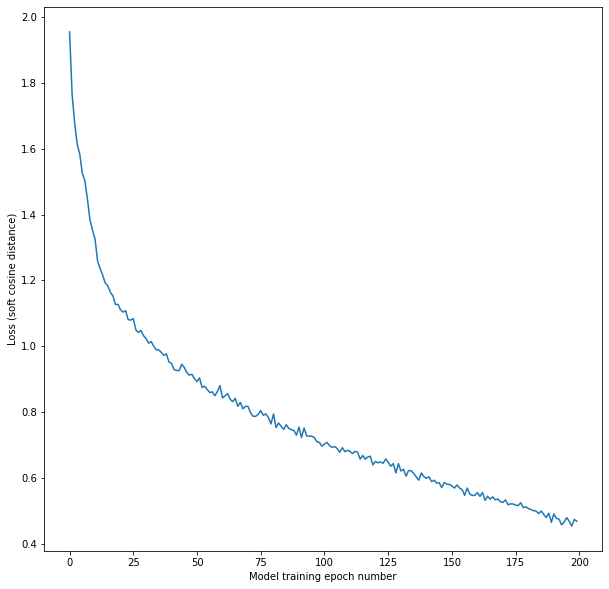

In [46]:
plt.figure(figsize = (10,10))
plt.plot(history.history["loss"])
plt.xlabel('Model training epoch number')
plt.ylabel('Loss (soft cosine distance)')
plt.show()

## Model evaluation

We can review the quality of this model by applying it to the test set and considering
near neighbours in the embedding space.

First we embed the test set and calculate all near neighbours. Recall that since the
embeddings are unit length we can calculate cosine similarity via dot products.


In [47]:
# code from https://keras.io/examples/vision/metric_learning/

embeddings = model.predict(x_test)

embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)

For more information about the inuition behind this approach, see this [blog post](http://matpalm.com/blog/einsum_example/) by the originator of this modeling approach, Matthew Kelcey 

Let's look the the mean and major recall scores for a range of number of nearest neighbours, from 1 to 20

In [48]:
max_num_near_neighbours = 20 

In [49]:
# code adapted from https://keras.io/examples/vision/metric_learning/

MN = []; MJ = []
for near_neighbours_per_example in np.arange(1,max_num_near_neighbours,1):

  near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

  confusion_matrix = np.zeros((num_classes, num_classes))

  # For each class.
  for class_idx in range(num_classes):
      # Consider 'near_neighbours' examples.
      example_idxs = class_idx_to_test_idxs[class_idx][:near_neighbours_per_example]
      for y_test_idx in example_idxs:
          # And count the classes of its near neighbours.
          for nn_idx in near_neighbours[y_test_idx][:-1]:
              nn_class_idx = y_test[nn_idx]
              #tally that class pairing 
              confusion_matrix[class_idx, nn_class_idx] += 1
  
  # normalize by row totals to make the matrix stochastic
  confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
  
  # mean recall as the mean of diagonal elements
  MN.append(np.mean(np.diag(confusion_matrix)))
  # maximum recall
  MJ.append(np.max(np.diag(confusion_matrix)))


Plot both of those scores as a function of nearest neighbours

Text(0.5, 0, 'number of nearest neighbours')

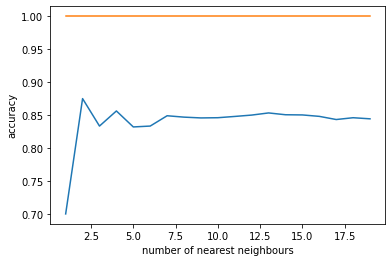

In [50]:
plt.plot(np.arange(1,max_num_near_neighbours,1), MN)
plt.plot(np.arange(1,max_num_near_neighbours,1), MJ)
plt.ylabel('accuracy')
plt.xlabel('number of nearest neighbours')

The "optimal" number of nearest neighbours is found as that which maximizes the mean recall score

In [51]:
near_neighbours_per_example = np.argmax(MN)+1 
print(near_neighbours_per_example)

2


### Evaluate the model using the train set

Get embeddings, Gramarian matrix and nearest neighbours for the training set, to see how well the model fits to the training data

(it should be a foregone conclusion that the model does well in this regard)

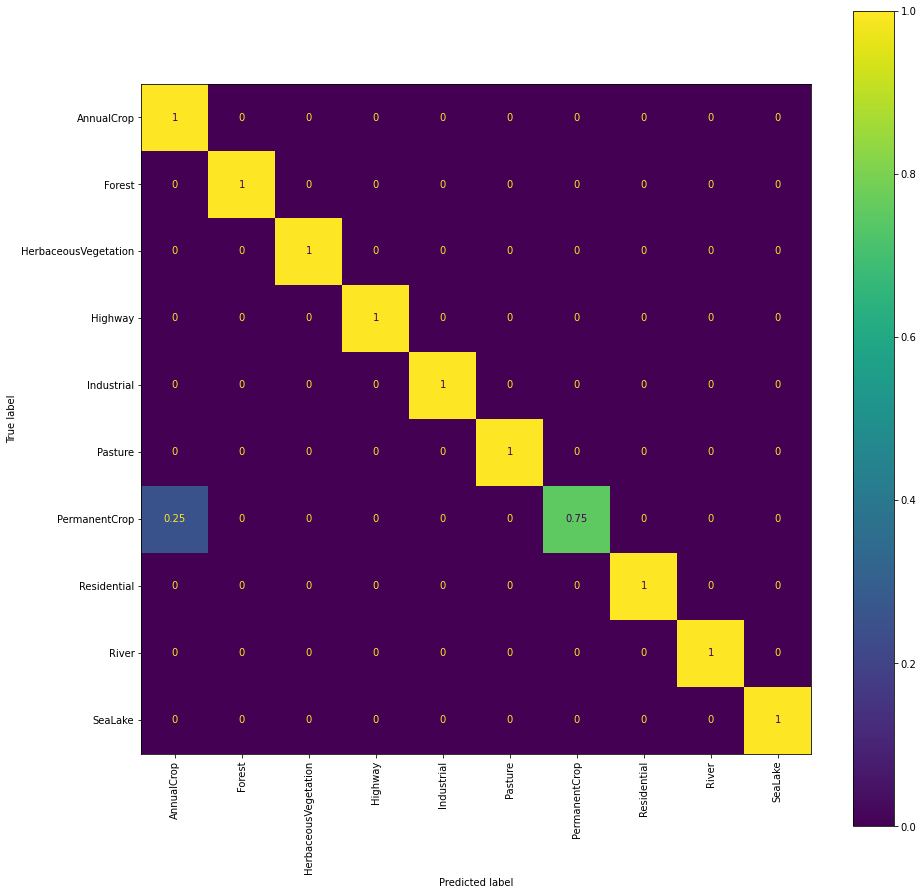

In [52]:
# code adapted from https://keras.io/examples/vision/metric_learning/

embeddings = model.predict(x_train)

embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider "near_neighbours_per_example" examples.
    example_idxs = class_idx_to_train_idxs[class_idx][:near_neighbours_per_example]
    for y_train_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_train_idx][:-1]:
            nn_class_idx = y_train[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
# Display a confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
# plt.show()

### Evaluate the model using the test set

Now the real test - how well does the model do on unseen test imagery?

Get the embeddings, gramarian matrix and nearest neighbours for the test set

In [53]:
embeddings = model.predict(x_test)

embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

Get and display the confusion matrix for the test set

Mean accuracy: 0.875000


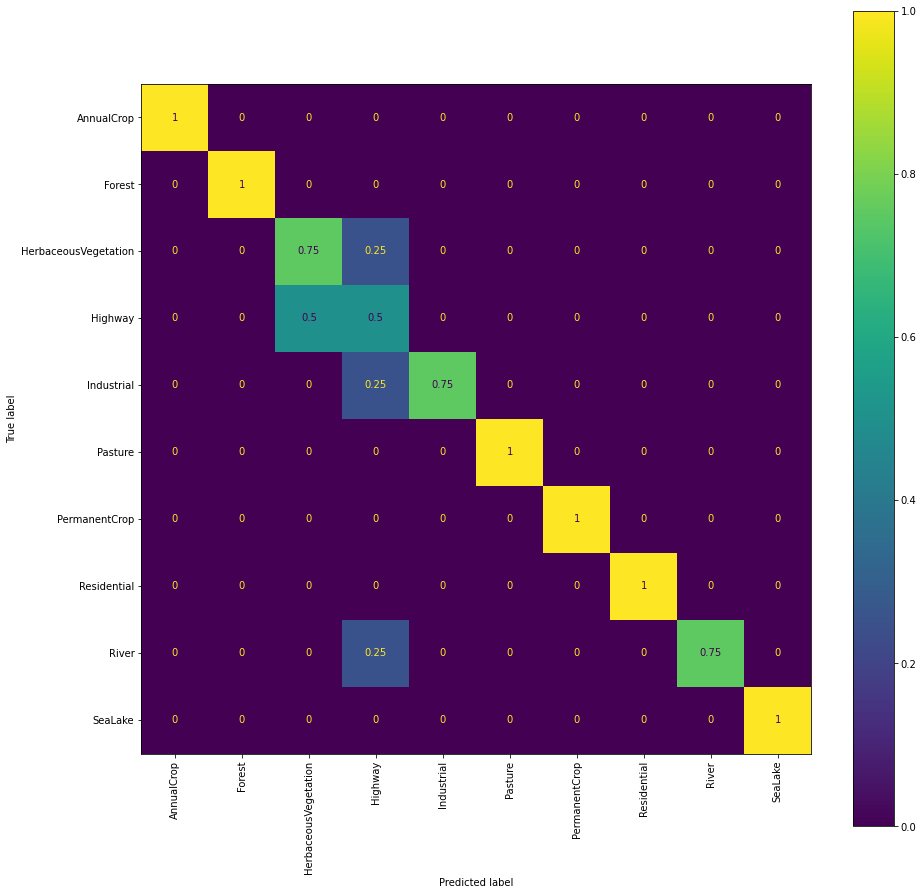

In [54]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider "near_neighbours_per_example examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:near_neighbours_per_example]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
# Display a confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
# plt.show()

print("Mean accuracy: %f" % (np.mean(np.diag(confusion_matrix))))

There is confusion between the vegetation types, but overall accuracy is > 80%

### Make and evaluate an ensemble model using a range of near neighbours

Compute a confusion matrix for the model, utilizing varying numbers of near neighbours

In [55]:
min_neighbours = 2
max_neighbours = 10

In [56]:
CM = []

for near_neighbours_per_example in np.arange(min_neighbours,max_neighbours,1):

  near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]
  confusion_matrix = np.zeros((num_classes, num_classes))

  # For each class.
  for class_idx in range(num_classes):
      # Consider 10 examples.
      example_idxs = class_idx_to_test_idxs[class_idx][:near_neighbours_per_example] #[:10]
      for y_test_idx in example_idxs:
          # And count the classes of its near neighbours.
          for nn_idx in near_neighbours[y_test_idx][:-1]:
              #print("dist: %f, class: %i" % (gram_matrix[nn_idx, nn_idx], y_test[nn_idx]))
              nn_class_idx = y_test[nn_idx]
              confusion_matrix[class_idx, nn_class_idx] += 1
  CM.append(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])


Get the mean confusion matrix

Mean accuracy: 0.846431


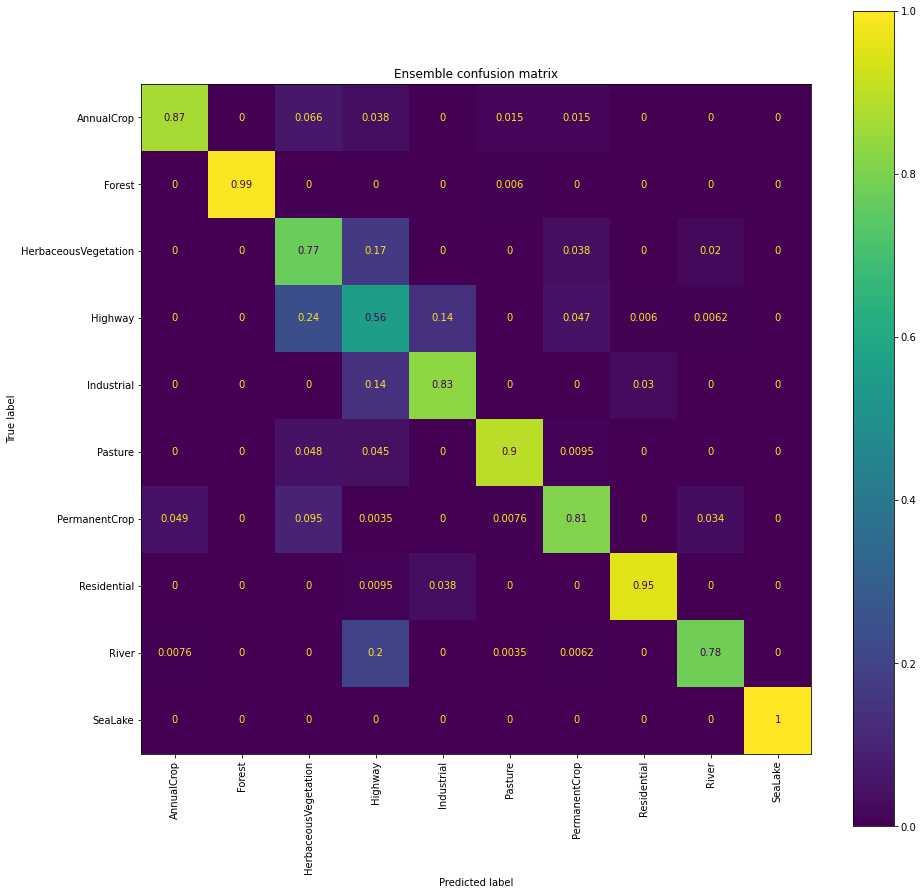

In [57]:
cm = np.mean(CM, axis=0)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
# Display a confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.title("Ensemble confusion matrix")

print("Mean accuracy: %f" % (np.mean(np.diag(cm))))

### Variability index

One index of sensitivity (sensitivity to specification of number of nearest neighbours) is the variability of prediction accuracies for each class, as a function of number of nearest neighbours, is the coefficient of variation

Low values indicate classes that are relatively insesntive to the specification of number of nearest neighbours

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Variability Index, %')

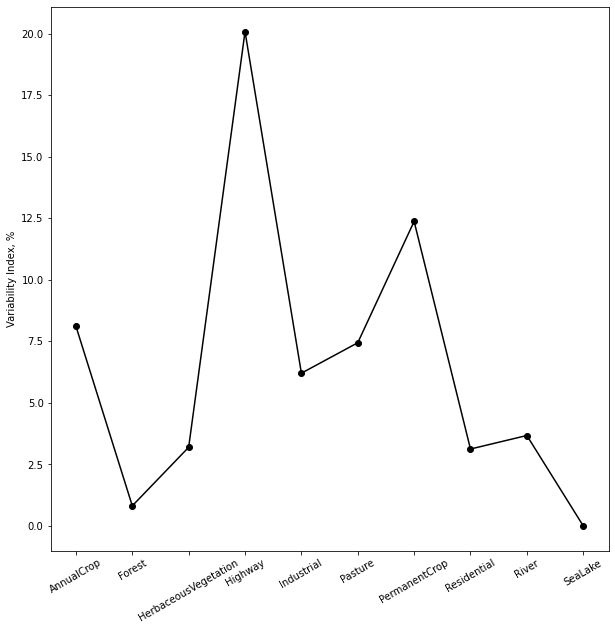

In [58]:
cmv2 = np.std(CM, axis=0) / np.mean(CM, axis=0)

plt.figure(figsize=(10,10))
ax = plt.subplot(111) 
ax.plot(100*np.diag(cmv2), 'k-o')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=10, rotation=30)
plt.ylabel('Variability Index, %')

## Estimate class likelihoods for an example test image

We choose an image from the test set (below we use image 1000, but it could be any)

Then we get the model to predict the embedding for the image (`e`) and use the Gramarian matrix again to get the nearest neighbours (we ask for 3)

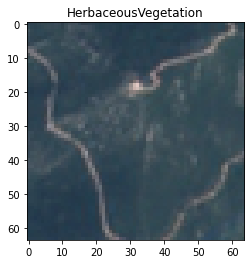

In [59]:
# index in x_test
k =1000

near_neighbours_per_example = 3

plt.imshow(x_test[k])
plt.title(classes[y_test[k]])

e = model.predict(np.expand_dims(x_test[k],0))

near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]


Find the indices of that class in the testing set

In [60]:
class_idx = int(np.where(np.array(classes) == classes[y_test[k]])[0])

example_idxs = class_idx_to_test_idxs[class_idx][:near_neighbours_per_example] 

#print(example_idxs)

Get the classes of those near neighbours

In [61]:
N = []
for y_test_idx in example_idxs:
   for nn_idx in near_neighbours[y_test_idx][:-1]:
      nn_class_idx = y_test[nn_idx]
      N.append(nn_class_idx)

The likelihood of each class (in the frequentist sense) is how many times each class is represented in the nearest neighbours of the target class

Text(0, 0.5, 'Likelihood, %')

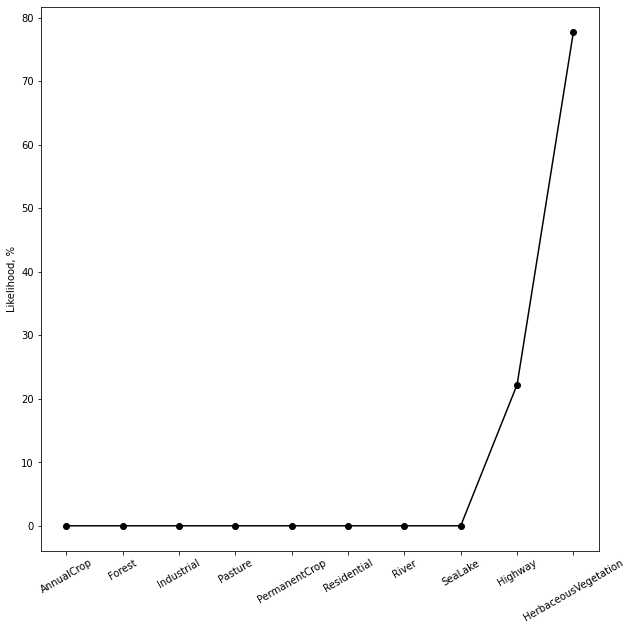

In [62]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111) 

score = 100*(np.bincount(N, minlength=len(classes))/len(N))

ind = np.argsort(score)

ax.plot(score[ind], 'k-o')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(np.array(classes)[ind], fontsize=10, rotation=30)
plt.ylabel('Likelihood, %')

Extending the above to the ensemble model approach would look like this

In [63]:
N = []
for near_neighbours_per_example in np.arange(min_neighbours,max_neighbours,1):
   near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

   class_idx = int(np.where(np.array(classes) == classes[y_test[k]])[0])

   example_idxs = class_idx_to_test_idxs[class_idx][:near_neighbours_per_example] 

   for y_test_idx in example_idxs:
      for nn_idx in near_neighbours[y_test_idx][:-1]:
         nn_class_idx = y_test[nn_idx]
         N.append(nn_class_idx)

Text(0, 0.5, 'Likelihood, %')

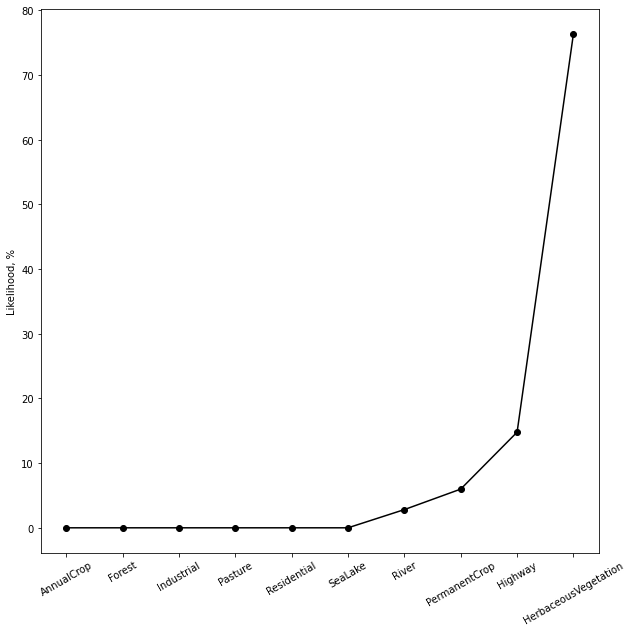

In [64]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111) 

score = 100*(np.bincount(N, minlength=len(classes))/len(N))

ind = np.argsort(score)

ax.plot(score[ind], 'k-o')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(np.array(classes)[ind], fontsize=10, rotation=30)
plt.ylabel('Likelihood, %')

## Visualizing classes as clusters in embedded space

Another way to examine the variability of class predictions (and potentially another way to compute a per-sample metric of model goodness-of-fit) is to use a clustering algorithm on the embeddings predicted by the model

Below we carry out the dimensionality reduction using t-distributed Stochastic Neighbor Embedding or t-SNE

We use the sciki-learn TSNE function to compute the projection in 2 dimensions, then we use K-Means to cluster the data per class

In [65]:
from sklearn.manifold import TSNE

First, let's look at the training data

Get the embeddings from the train set, then compute two t-SNE components from the data

In [66]:
embeddings = model.predict(x_train)

embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

tl=TSNE(n_components=2, metric='cosine')
embedding_tsne=tl.fit_transform(embeddings)

In [67]:
embedding_tsne.shape

(9999, 2)

Use K-Means++ to find clusters in the two t-sne dimensions corresponding to each class

In [68]:
from sklearn.cluster import KMeans

In [69]:
kmeans = KMeans(init='k-means++', n_clusters=num_classes, n_init=10)
kmeans.fit(embedding_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [70]:
## adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embedding_tsne[:, 0].min() - 1, embedding_tsne[:, 0].max() + 1
y_min, y_max = embedding_tsne[:, 1].min() - 1, embedding_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


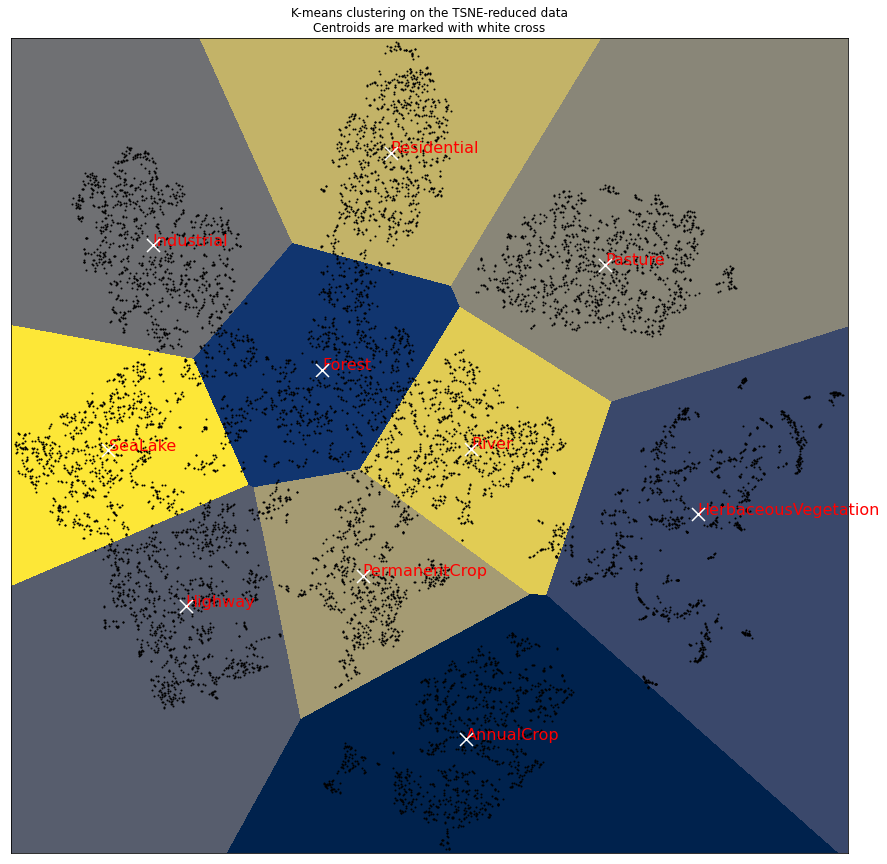

In [71]:
# Put the result into a color plot
plt.figure(figsize=(15,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.cividis, #plt.cm.Paired,
           aspect='auto', origin='lower')

# plot TSNE embeddings
plt.plot(embedding_tsne[:, 0], embedding_tsne[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the TSNE-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

for k in range(num_classes):
   ind = np.where(kmeans.labels_ == k)[0]
   plt.text(np.mean(embedding_tsne[ind, 0]), np.mean(embedding_tsne[ind, 1]), \
            classes[k] , color='r', fontsize=16)


As expected, the clusters seperate nicely

Now, let's look at the test data

In [72]:
embeddings_test = model.predict(x_test)

embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

tl=TSNE(n_components=2,  metric='cosine')
embedding_tsne_test = tl.fit_transform(embeddings_test)

In [73]:
kmeans = KMeans(init='k-means++', n_clusters=num_classes, n_init=10)
kmeans.fit(embedding_tsne_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [74]:
## adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embedding_tsne_test[:, 0].min() - 1, embedding_tsne_test[:, 0].max() + 1
y_min, y_max = embedding_tsne_test[:, 1].min() - 1, embedding_tsne_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


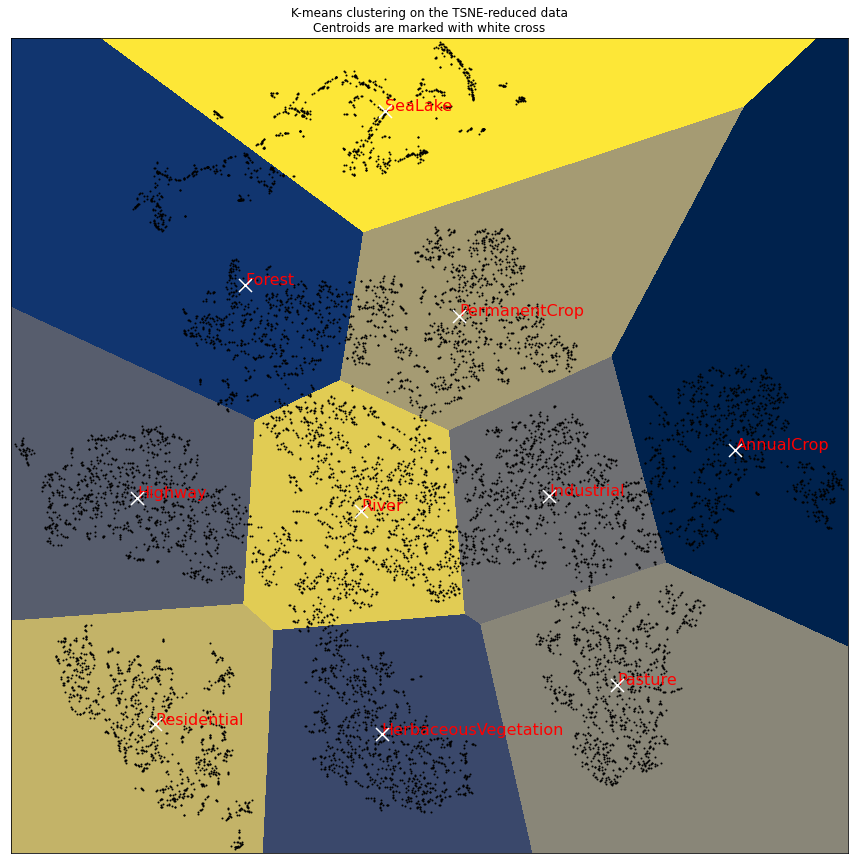

In [75]:
# Put the result into a color plot
plt.figure(figsize=(15,15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.cividis, #plt.cm.Paired,
           aspect='auto', origin='lower')

# plot TSNE embeddings
plt.plot(embedding_tsne_test[:, 0], embedding_tsne_test[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the TSNE-reduced data\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

for k in range(num_classes):
   ind = np.where(kmeans.labels_ == k)[0]
   plt.text(np.mean(embedding_tsne_test[ind, 0]), np.mean(embedding_tsne_test[ind, 1]), \
            classes[k] , color='r', fontsize=16)


The clusters are less regular and distinct. We leave it as an exercise to the interested reader to adapt this methodology for evaluating the model fit on a sample image by sample image basis